In [1]:
from pathlib import Path

thispath = Path('__file__').resolve()
base_path = thispath.parent.parent
import sys; sys.path.insert(0, str(base_path))
from dataset.copd_dataset import DirLabCOPD

import matplotlib.pyplot as plt
import preprocess.preprocess as preprocess
from utils import metrics
import time
import pandas as pd
import ants
import numpy as np
from tqdm import tqdm
import json
import antspy.ants_utils as a_utils

In [2]:
# Dataset
data_path = Path('/home/kaouther/Documents/GitHub/mira_final_project/data')

data = DirLabCOPD(
    data_path=data_path,
    cases=['all'],
    partitions=['train'],
    return_lm_mask=False,
    normalization_cfg=None,
    return_body_masks=False,
    return_lung_masks=True
)

In [3]:
len(data)

4

## Demonstration

In [42]:
sample = data[0]
fixed = ants.image_read(sample['e_img_path']) 
spacing = fixed.spacing
origin = fixed.origin
direction = fixed.direction

In [43]:
fixed = ants.from_numpy(sample['e_img'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)
moving = ants.from_numpy(sample['i_img'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)

In [44]:
mask_fix = ants.from_numpy(sample['e_lung_mask'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)
mask_mov = ants.from_numpy(sample['i_lung_mask'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)

In [45]:
fixed = ants.iMath(fixed, 'Normalize', 0.0, 1.0)
# fixed = ants.iMath_truncate_intensity( fixed, 0.05, 0.95)
moving = ants.iMath(moving, 'Normalize', 0.0, 1.0)
# moving = ants.iMath_truncate_intensity(moving, 0.05, 0.95 )

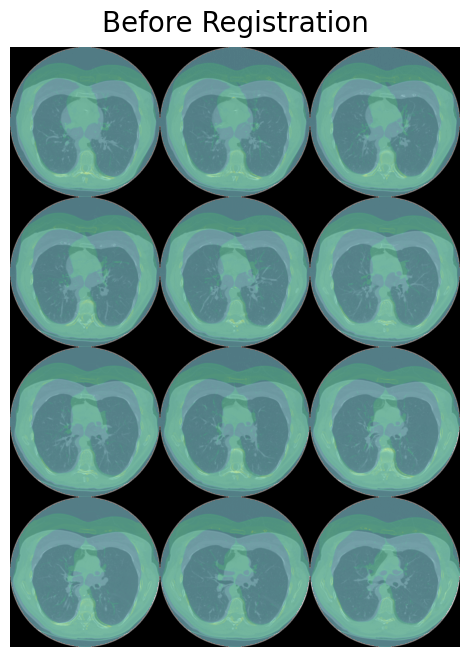

In [46]:
fixed.plot(overlay=moving, title='Before Registration', cmap='gray', overlay_cmap='viridis', overlay_alpha=0.5, axis=2)

In [47]:
mytx = ants.registration(fixed=fixed, 
                         moving=moving, 
                         aff_iterations=(100, 100, 100, 50, 0),
                         aff_shrink_factors=(8, 6, 4, 2, 1),
                         aff_smoothing_sigmas=(10, 1, 0, 0, 0),
                         flow_sigma= 10,
                         total_sigma= 0.25,
                         type_of_transform="SyNOnly",
                         syn_sampling=32,
                         reg_iterations=(100, 100, 50, 0, 0),
                         syn_metric='meansquares',
                         verbose=True,
                         )

antsRegistration -d 3 -r [0x55db184e83d0,0x55db04ea1140,1] -m meansquares[0x55db184e83d0,0x55db04ea1140,1,32] -t SyN[0.200000,10.000000,0.250000] -c [100x100x50x0x0,1e-7,8] -s 4x3x2x1x0 -f 16x8x4x2x1 -u 1 -z 1 -o [/tmp/tmp25h7l0l1,0x55db1847aa30,0x55db1c9b67b0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass alignment using fixed image: 0x55db184e83d0 and moving image: 0x55db04ea1140 (type = Euler3DTransform)
  Reading mask(s).
    Registration stage 0
      No fixed mask
      No moving mask
  number of levels = 5
  fixed image: 0x55db184e83d0
  moving image: 0x55db04ea1140
Dimension = 3
Number of stages = 1
Use Histogram Matching true
Winsorize image intensities false
Lower quantile = 0
Upper quantile = 1
Stage 1 State
   Image metric = MeanSquares
     Fixed image = Image (0x55db1d228c70)
  RTTI typeinfo:   itk::Image<float

In [48]:
registered = mytx['warpedmovout']

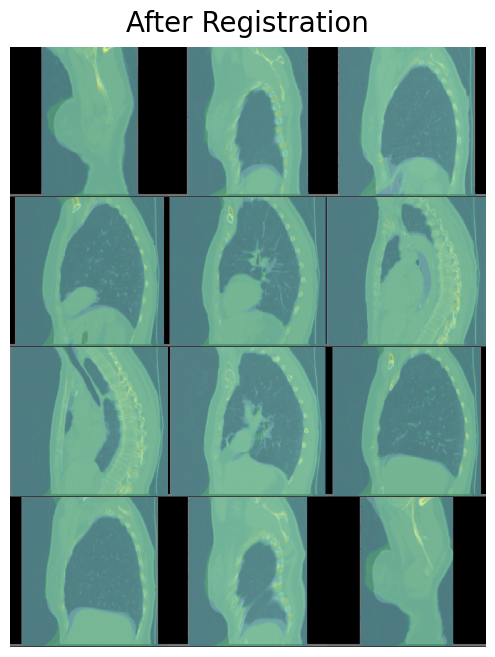

In [49]:
fixed.plot(overlay=registered, title='After Registration', cmap='gray', overlay_cmap='viridis', overlay_alpha=0.5, axis=0)

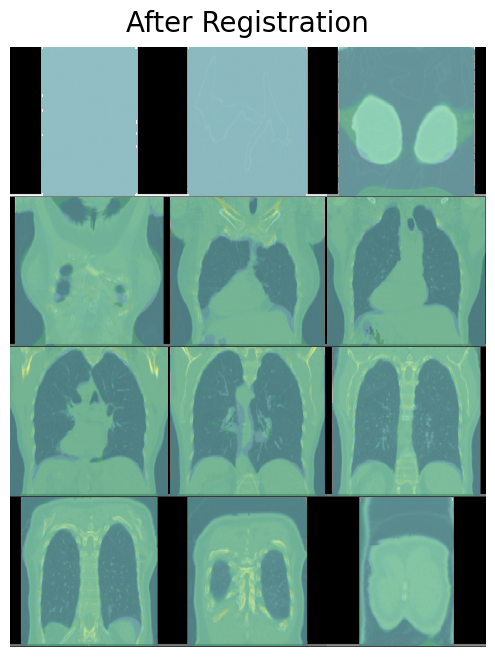

In [50]:
fixed.plot(overlay=registered, title='After Registration', cmap='gray', overlay_cmap='viridis', overlay_alpha=0.5, axis=1)

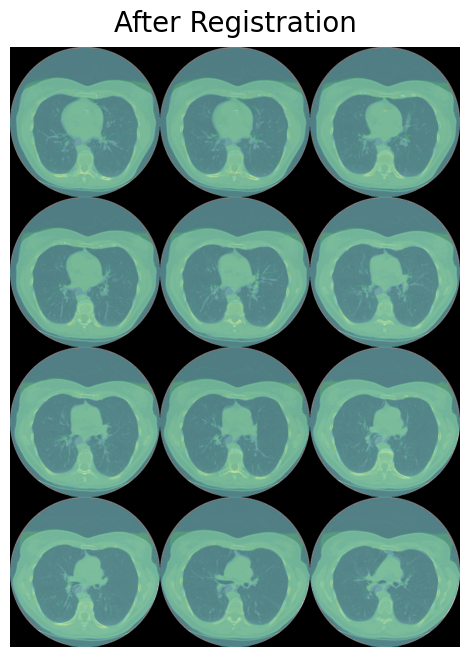

In [51]:
fixed.plot(overlay=registered, title='After Registration', cmap='gray', overlay_cmap='viridis', overlay_alpha=0.5, axis=2)

In [52]:
mytx['invtransforms']

['/tmp/tmp25h7l0l10GenericAffine.mat', '/tmp/tmp25h7l0l11InverseWarp.nii.gz']

In [53]:
case_path = Path(sample['i_img_path']).parent
lm_filepath_fixed = case_path / f"{sample['case']}_eBHCT_lm.csv"
lm_filepath_moving = case_path / f"{sample['case']}_iBHCT_lm.csv"
landmarks_fixed_df = pd.read_csv(lm_filepath_fixed)
landmarks_moving_df = pd.read_csv(lm_filepath_moving)

landmarks_fixed_df = landmarks_fixed_df[['x', 'y','z']]
landmarks_moving_df = landmarks_moving_df[['x', 'y','z']]

landmarks_fixed = landmarks_fixed_df.to_numpy(dtype=np.float32)

landmarks_result = ants.apply_transforms_to_points(3, landmarks_moving_df, mytx['invtransforms'], whichtoinvert=[True, False]).to_numpy(dtype=np.float32)
tre = metrics.target_registration_error(landmarks_result, landmarks_fixed, [1.0, 1.0, 1.0])

print(f'TRE: {tre[0]}, {tre[1]}')
print(f'Initial displacement GT: {sample["disp_mean"]}, {sample["disp_std"]}')

TRE: 10.79, 6.08
Initial displacement GT: 25.9, 11.57


## Experiments

In [3]:
def run_experiment(data: DirLabCOPD, exp_name: str, reg_parameters:dict, pp_parameters:dict = None):
    """
    Function that runs an experiment on the whole dataset for some parameters
    args:
        data (DirLabCOPD): dataset with the images to be registered
        exp_name (str): name to save the experiment results
        reg_parameters (dict): parameters to use for the registration 
        pp_parameters (dict): preprocessing parameters
    returns: nothing
    """

    res_dir = Path('/home/kaouther/Documents/GitHub/mira_final_project/antspy/transforms')
    results_exp = {}
    for i in tqdm(range(len(data))):
        sample = data[i]
        res_path = res_dir/ exp_name / sample['case']
        res_path.mkdir(exist_ok=True, parents=True)
        
        fixed = ants.image_read(sample['e_img_path']) 
        spacing = fixed.spacing
        origin = fixed.origin
        direction = fixed.direction

        fixed = ants.from_numpy(sample['e_img'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)
        moving = ants.from_numpy(sample['i_img'].astype(np.float32), spacing=spacing, direction=direction, origin=origin)

        if pp_parameters is not None:
            fixed = a_utils.ants_preprocess(fixed, pp_parameters['norm_min'], pp_parameters['norm_max'], pp_parameters['trunc_min'], pp_parameters['trunc_max'])
            moving = a_utils.ants_preprocess(moving, pp_parameters['norm_min'], pp_parameters['norm_max'], pp_parameters['trunc_min'], pp_parameters['trunc_max'])

        mytx, reg_time = a_utils.ants_register(fixed, 
                                               moving,
                                               reg_parameters['transform'],
                                               reg_parameters['metric'],
                                               reg_parameters['sampling'],
                                               reg_parameters['iterations'])

        case_path = Path(sample['i_img_path']).parent
        lm_filepath_fixed = case_path / f"{sample['case']}_eBHCT_lm.csv"
        lm_filepath_moving = case_path / f"{sample['case']}_iBHCT_lm.csv"
        landmarks_fixed_df = pd.read_csv(lm_filepath_fixed)
        landmarks_moving_df = pd.read_csv(lm_filepath_moving)

        landmarks_fixed, landmarks_result = a_utils.ants_transform_landmarks(landmarks_fixed_df, landmarks_moving_df, mytx['invtransforms'])

        tre = metrics.target_registration_error(landmarks_result, landmarks_fixed, [1.0, 1.0, 1.0])
        
        results_exp[sample['case']] = {
                'mean_tre': tre[0],
                'std_tre': tre[1],
                'time': reg_time,
            }

    return results_exp

In [4]:
results_path = base_path / 'experiments/ants/results.json'

### Exp 01

In [56]:
exp_name = 'baseline'

reg_params = {'transform': 'SyNOnly',
              'metric': 'meansquares',
              'sampling': 32,
              'iterations': (100, 100, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.0,
             'trunc_max': 1.0}

In [57]:
exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

100%|██████████| 4/4 [10:06<00:00, 151.53s/it]


In [58]:
exp_results

{'copd1': {'mean_tre': 9.15, 'std_tre': 5.07, 'time': 131.99574851989746},
 'copd2': {'mean_tre': 14.76, 'std_tre': 6.13, 'time': 108.16086220741272},
 'copd3': {'mean_tre': 6.17, 'std_tre': 3.28, 'time': 170.30842185020447},
 'copd4': {'mean_tre': 11.02, 'std_tre': 3.89, 'time': 176.95721864700317}}

### Exp 02

In [59]:
exp_name = 'preprocessing_05_95'

reg_params = {'transform': 'SyNOnly',
              'metric': 'meansquares',
              'sampling': 32,
              'iterations': (100, 100, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.05,
             'trunc_max': 0.95}

In [60]:
exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [10:06<00:00, 151.62s/it]


{'copd1': {'mean_tre': 8.95, 'std_tre': 5.06, 'time': 131.4254081249237},
 'copd2': {'mean_tre': 14.8, 'std_tre': 6.18, 'time': 109.21235060691833},
 'copd3': {'mean_tre': 5.96, 'std_tre': 3.29, 'time': 169.6865062713623},
 'copd4': {'mean_tre': 11.09, 'std_tre': 4.01, 'time': 177.46313786506653}}

### Exp 03

In [61]:
exp_name = 'preprocessing_15_85'

reg_params = {'transform': 'SyNOnly',
              'metric': 'meansquares',
              'sampling': 32,
              'iterations': (100, 100, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.15,
             'trunc_max': 0.85}

In [62]:
exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [10:14<00:00, 153.58s/it]


{'copd1': {'mean_tre': 8.91, 'std_tre': 5.04, 'time': 132.5869562625885},
 'copd2': {'mean_tre': 14.79, 'std_tre': 6.29, 'time': 106.34393835067749},
 'copd3': {'mean_tre': 5.87, 'std_tre': 3.29, 'time': 174.20588397979736},
 'copd4': {'mean_tre': 11.1, 'std_tre': 4.08, 'time': 181.82998538017273}}

### Exp 04

In [72]:
exp_name = 'SyNOnly_mse_32'

reg_params = {'transform': 'SyNOnly',
              'metric': 'meansquares',
              'sampling': 32,
              'iterations': (100, 100, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.15,
             'trunc_max': 0.85}

In [73]:
exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [10:18<00:00, 154.68s/it]


{'copd1': {'mean_tre': 8.91, 'std_tre': 5.04, 'time': 135.0455174446106},
 'copd2': {'mean_tre': 14.79, 'std_tre': 6.29, 'time': 107.22312712669373},
 'copd3': {'mean_tre': 5.87, 'std_tre': 3.29, 'time': 174.0649652481079},
 'copd4': {'mean_tre': 11.1, 'std_tre': 4.08, 'time': 183.65703868865967}}

### Exp 05

In [74]:
exp_name = 'SyNOnly_demons_32'

reg_params = {'transform': 'SyNOnly',
              'metric': 'demons',
              'sampling': 32,
              'iterations': (100, 100, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.15,
             'trunc_max': 0.85}

In [75]:
exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [11:32<00:00, 173.17s/it]


{'copd1': {'mean_tre': 18.88, 'std_tre': 9.13, 'time': 167.0764970779419},
 'copd2': {'mean_tre': 21.01, 'std_tre': 9.64, 'time': 146.61071753501892},
 'copd3': {'mean_tre': 18.02, 'std_tre': 9.91, 'time': 180.25059723854065},
 'copd4': {'mean_tre': 18.03, 'std_tre': 6.95, 'time': 179.98518252372742}}

### Exp 06

In [76]:
exp_name = 'SyNOnly_gc_32'

reg_params = {'transform': 'SyNOnly',
              'metric': 'GC',
              'sampling': 32,
              'iterations': (100, 100, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.15,
             'trunc_max': 0.85}

In [77]:
exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [12:50<00:00, 192.69s/it]


{'copd1': {'mean_tre': 24.35, 'std_tre': 9.24, 'time': 194.50279784202576},
 'copd2': {'mean_tre': 21.52, 'std_tre': 6.06, 'time': 153.23273062705994},
 'copd3': {'mean_tre': 10.35, 'std_tre': 4.27, 'time': 201.27209401130676},
 'copd4': {'mean_tre': 25.66, 'std_tre': 7.59, 'time': 203.4854598045349}}

### Exp 07

In [78]:
exp_name = 'SyNOnly_mi_32'

reg_params = {'transform': 'SyNOnly',
              'metric': 'MI',
              'sampling': 32,
              'iterations': (100, 100, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.15,
             'trunc_max': 0.85}


exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [08:59<00:00, 134.97s/it]


{'copd1': {'mean_tre': 8.07, 'std_tre': 5.59, 'time': 141.85789227485657},
 'copd2': {'mean_tre': 13.34, 'std_tre': 6.24, 'time': 108.53491687774658},
 'copd3': {'mean_tre': 5.43, 'std_tre': 3.66, 'time': 122.8321144580841},
 'copd4': {'mean_tre': 16.45, 'std_tre': 5.86, 'time': 147.9155559539795}}

### Exp 08

In [84]:
exp_name = 'SyN_mse_32'

reg_params = {'transform': 'SyN',
              'metric': 'meansquares',
              'sampling': 32,
              'iterations': (100, 100, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.15,
             'trunc_max': 0.85}


exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [11:38<00:00, 174.64s/it]


{'copd1': {'mean_tre': 9.45, 'std_tre': 4.54, 'time': 167.57933688163757},
 'copd2': {'mean_tre': 15.17, 'std_tre': 5.98, 'time': 147.57146430015564},
 'copd3': {'mean_tre': 5.23, 'std_tre': 2.87, 'time': 173.75433444976807},
 'copd4': {'mean_tre': 12.11, 'std_tre': 3.86, 'time': 190.65411138534546}}

### Exp 09

In [85]:
exp_name = 'SyN_mi_32'

reg_params = {'transform': 'SyN',
              'metric': 'MI',
              'sampling': 32,
              'iterations': (100, 100, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.15,
             'trunc_max': 0.85}


exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [12:11<00:00, 182.77s/it]


{'copd1': {'mean_tre': 7.81, 'std_tre': 4.83, 'time': 182.3144268989563},
 'copd2': {'mean_tre': 13.59, 'std_tre': 6.15, 'time': 147.57477807998657},
 'copd3': {'mean_tre': 5.23, 'std_tre': 3.42, 'time': 178.2429256439209},
 'copd4': {'mean_tre': 12.86, 'std_tre': 4.24, 'time': 204.05964827537537}}

### Exp 10

In [86]:
exp_name = 'Elastic_mse_32'

reg_params = {'transform': 'Elastic',
              'metric': 'meansquares',
              'sampling': 32,
              'iterations': (100, 100, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.15,
             'trunc_max': 0.85}


exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [18:55<00:00, 283.88s/it]


{'copd1': {'mean_tre': 11.47, 'std_tre': 5.27, 'time': 264.508873462677},
 'copd2': {'mean_tre': 19.75, 'std_tre': 6.16, 'time': 214.45685172080994},
 'copd3': {'mean_tre': 9.9, 'std_tre': 3.62, 'time': 331.3605623245239},
 'copd4': {'mean_tre': 10.9, 'std_tre': 3.91, 'time': 305.6334171295166}}

### Exp 11

In [87]:
exp_name = 'Elastic_mi_32'

reg_params = {'transform': 'Elastic',
              'metric': 'MI',
              'sampling': 32,
              'iterations': (100, 100, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.15,
             'trunc_max': 0.85}


exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [13:07<00:00, 196.80s/it]


{'copd1': {'mean_tre': 11.16, 'std_tre': 5.17, 'time': 144.84232258796692},
 'copd2': {'mean_tre': 19.27, 'std_tre': 6.05, 'time': 220.35740518569946},
 'copd3': {'mean_tre': 9.88, 'std_tre': 3.59, 'time': 224.61919260025024},
 'copd4': {'mean_tre': 10.89, 'std_tre': 3.84, 'time': 177.7817018032074}}

### Exp 12

In [89]:
exp_name = 'ElasticSyN_mse_32'

reg_params = {'transform': 'ElasticSyN',
              'metric': 'meansquares',
              'sampling': 32,
              'iterations': (100, 100, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.15,
             'trunc_max': 0.85}


exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [12:13<00:00, 183.49s/it]


{'copd1': {'mean_tre': 9.14, 'std_tre': 4.61, 'time': 170.43841528892517},
 'copd2': {'mean_tre': 15.08, 'std_tre': 6.03, 'time': 140.1659722328186},
 'copd3': {'mean_tre': 5.87, 'std_tre': 3.0, 'time': 207.83580589294434},
 'copd4': {'mean_tre': 11.98, 'std_tre': 3.87, 'time': 196.91670894622803}}

### Exp 13

In [88]:
exp_name = 'ElasticSyN_mi_32'

reg_params = {'transform': 'ElasticSyN',
              'metric': 'MI',
              'sampling': 32,
              'iterations': (100, 100, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.15,
             'trunc_max': 0.85}


exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [11:29<00:00, 172.50s/it]


{'copd1': {'mean_tre': 7.99, 'std_tre': 4.83, 'time': 172.67436480522156},
 'copd2': {'mean_tre': 13.94, 'std_tre': 6.3, 'time': 131.53199887275696},
 'copd3': {'mean_tre': 5.58, 'std_tre': 3.57, 'time': 173.72167325019836},
 'copd4': {'mean_tre': 13.44, 'std_tre': 4.43, 'time': 193.36764764785767}}

### Exp 14 

In [94]:
exp_name = 'SyN_mi_16'

reg_params = {'transform': 'SyN',
              'metric': 'MI',
              'sampling': 16,
              'iterations': (100, 100, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.15,
             'trunc_max': 0.85}


exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [12:33<00:00, 188.43s/it]


{'copd1': {'mean_tre': 7.78, 'std_tre': 4.55, 'time': 197.1348807811737},
 'copd2': {'mean_tre': 13.56, 'std_tre': 6.35, 'time': 138.78453493118286},
 'copd3': {'mean_tre': 4.78, 'std_tre': 3.21, 'time': 184.36603546142578},
 'copd4': {'mean_tre': 11.21, 'std_tre': 4.33, 'time': 214.54606866836548}}

### Exp 15

In [95]:
exp_name = 'SyN_mi_8'

reg_params = {'transform': 'SyN',
              'metric': 'MI',
              'sampling': 8,
              'iterations': (100, 100, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.15,
             'trunc_max': 0.85}


exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [10:48<00:00, 162.13s/it]


{'copd1': {'mean_tre': 8.65, 'std_tre': 4.63, 'time': 122.51822662353516},
 'copd2': {'mean_tre': 14.17, 'std_tre': 6.15, 'time': 140.4054732322693},
 'copd3': {'mean_tre': 4.93, 'std_tre': 3.09, 'time': 163.45569372177124},
 'copd4': {'mean_tre': 10.49, 'std_tre': 4.13, 'time': 203.24974656105042}}

### Exp 16

In [103]:
exp_name = 'SyN_mi_4'

reg_params = {'transform': 'SyN',
              'metric': 'MI',
              'sampling': 4,
              'iterations': (100, 100, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.15,
             'trunc_max': 0.85}


exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [08:00<00:00, 120.14s/it]


{'copd1': {'mean_tre': 11.94, 'std_tre': 5.09, 'time': 87.73847270011902},
 'copd2': {'mean_tre': 19.45, 'std_tre': 6.16, 'time': 122.28159093856812},
 'copd3': {'mean_tre': 8.97, 'std_tre': 3.42, 'time': 117.4570369720459},
 'copd4': {'mean_tre': 19.55, 'std_tre': 4.07, 'time': 135.1019048690796}}

### Exp 17

In [5]:
exp_name = 'SyN_mi_16_2'

reg_params = {'transform': 'SyN',
              'metric': 'MI',
              'sampling': 16,
              'iterations': (120, 120, 75, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.15,
             'trunc_max': 0.85}


exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [16:30<00:00, 247.56s/it]


{'copd1': {'mean_tre': 7.74, 'std_tre': 4.56, 'time': 281.42702531814575},
 'copd2': {'mean_tre': 13.63, 'std_tre': 6.51, 'time': 183.12569975852966},
 'copd3': {'mean_tre': 5.18, 'std_tre': 3.72, 'time': 236.99659276008606},
 'copd4': {'mean_tre': 11.04, 'std_tre': 4.5, 'time': 268.4792115688324}}

### Exp 18

In [9]:
exp_name = 'SyN_mi_16_3'

reg_params = {'transform': 'SyN',
              'metric': 'MI',
              'sampling': 16,
              'iterations': (100, 100, 50, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.15,
             'trunc_max': 0.85}


exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [36:11<00:00, 542.78s/it]


{'copd1': {'mean_tre': 8.1, 'std_tre': 5.34, 'time': 551.2131245136261},
 'copd2': {'mean_tre': 14.67, 'std_tre': 6.53, 'time': 468.38398718833923},
 'copd3': {'mean_tre': 5.19, 'std_tre': 3.35, 'time': 498.8899304866791},
 'copd4': {'mean_tre': 19.36, 'std_tre': 4.57, 'time': 632.3381400108337}}

### Exp 19

In [10]:
exp_name = 'SyN_mi_16_4'

reg_params = {'transform': 'SyN',
              'metric': 'MI',
              'sampling': 16,
              'iterations': (100, 100, 50, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.15,
             'trunc_max': 0.85}


exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [12:51<00:00, 192.86s/it]


{'copd1': {'mean_tre': 8.18, 'std_tre': 4.5, 'time': 212.81124138832092},
 'copd2': {'mean_tre': 14.86, 'std_tre': 7.02, 'time': 134.32276892662048},
 'copd3': {'mean_tre': 4.99, 'std_tre': 3.75, 'time': 202.36470437049866},
 'copd4': {'mean_tre': 9.39, 'std_tre': 5.03, 'time': 201.74385738372803}}

### Exp 20

In [15]:
exp_name = 'SyN_mi_16_5'

reg_params = {'transform': 'SyN',
              'metric': 'MI',
              'sampling': 16,
              'iterations': (100, 100, 50, 0, 0)
              }

pp_params = {'norm_min': 0.0,
             'norm_max': 0.1,
             'trunc_min': 0.1,
             'trunc_max': 0.9}


exp_results = run_experiment(data, exp_name, reg_params, pp_params)

with open(results_path, 'r') as json_file:
    results = json.load(json_file)

results[exp_name] = exp_results
with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

exp_results

100%|██████████| 4/4 [13:31<00:00, 202.76s/it]


{'copd1': {'mean_tre': 7.92, 'std_tre': 4.53, 'time': 222.82529211044312},
 'copd2': {'mean_tre': 13.88, 'std_tre': 6.56, 'time': 142.93714332580566},
 'copd3': {'mean_tre': 5.09, 'std_tre': 3.55, 'time': 193.45957684516907},
 'copd4': {'mean_tre': 9.44, 'std_tre': 4.14, 'time': 232.6050000190735}}

## Plots

In [16]:
base_path = Path().resolve().parent
results_path = base_path / 'experiments/ants/results.json'
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
df = []
for exp_name in results.keys():
    if results[exp_name] is None:
        row = [None, None, None, None, None]
    else:
        for case in results[exp_name].keys():
            columns = ['exp_name'] + list(results[exp_name][case].keys()) + ['case']
            row = [exp_name] + list(results[exp_name][case].values()) + [case]
            df.append(row)
df = pd.DataFrame(df, columns=columns)
df

,exp_name,mean_tre,std_tre,time,case
0,baseline,9.15,5.07,131.995749,copd1
1,baseline,14.76,6.13,108.160862,copd2
2,baseline,6.17,3.28,170.308422,copd3
3,baseline,11.02,3.89,176.957219,copd4
4,preprocessing_05_95,8.95,5.06,131.425408,copd1
...,...,...,...,...,...
75,SyN_mi_16_4,9.39,5.03,201.743857,copd4
76,SyN_mi_16_5,7.92,4.53,222.825292,copd1
77,SyN_mi_16_5,13.88,6.56,142.937143,copd2
78,SyN_mi_16_5,5.09,3.55,193.459577,copd3


In [18]:
df[['exp_name', 'time', 'mean_tre', 'std_tre']].groupby(['exp_name']).mean()

,time,mean_tre,std_tre
exp_name,,,
ElasticSyN_mi_32,167.823921,10.2375,4.7825
ElasticSyN_mse_32,178.839226,10.5175,4.3775
Elastic_mi_32,191.900156,12.8000,4.6625
Elastic_mse_32,278.989926,13.0050,4.7400
SyNOnly_demons_32,168.480749,18.9850,8.9075
SyNOnly_gc_32,188.123271,20.4700,6.7900
SyNOnly_mi_32,130.285120,10.8225,5.3375
SyNOnly_mse_32,149.997662,10.1675,4.6750
SyN_mi_16,183.707880,9.3325,4.6100


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


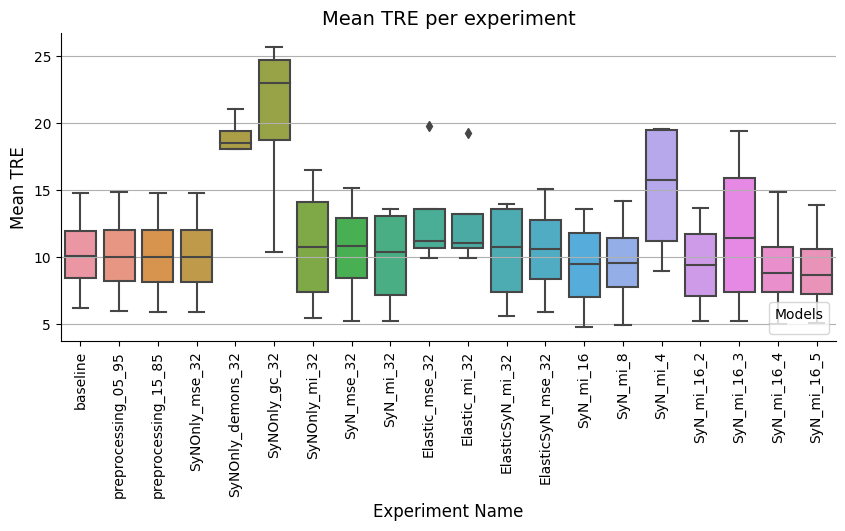

In [21]:
plt.figure(figsize=(10, 4))
plt.title('Mean TRE per experiment', fontsize=14)
sns.boxplot(data=df, x="exp_name", y="mean_tre")
sns.despine()
plt.grid(axis='y')
plt.xlabel('Experiment Name', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Mean TRE', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.pause(0.01)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


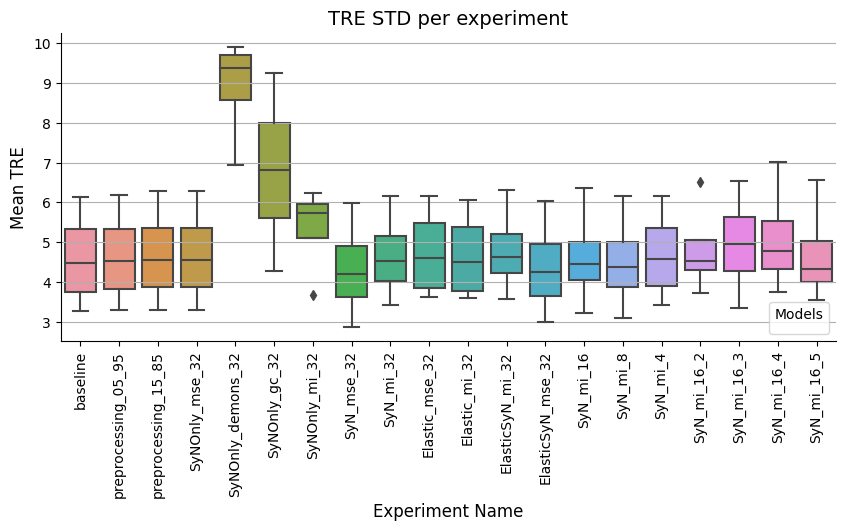

In [22]:
plt.figure(figsize=(10, 4))
plt.title('TRE STD per experiment', fontsize=14)
sns.boxplot(data=df, x="exp_name", y="std_tre")
sns.despine()
plt.grid(axis='y')
plt.xlabel('Experiment Name', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Mean TRE', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.pause(0.01)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


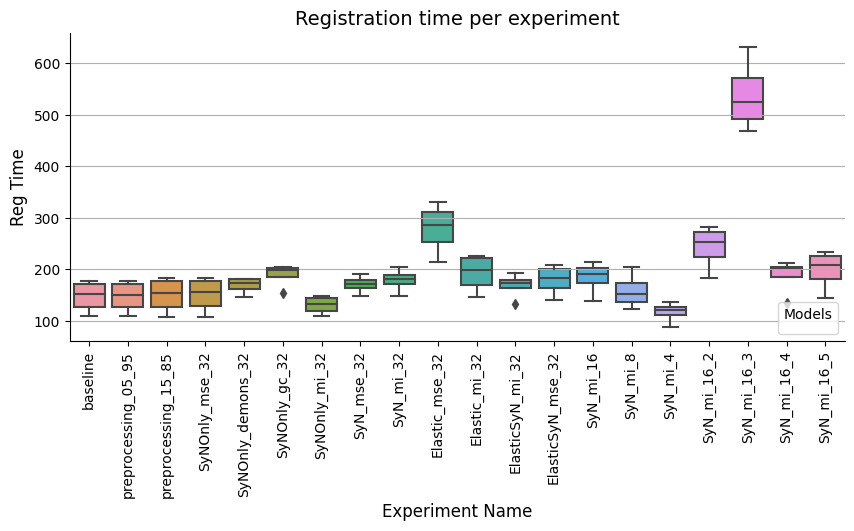

In [23]:
plt.figure(figsize=(10, 4))
plt.title('Registration time per experiment', fontsize=14)
sns.boxplot(data=df, x="exp_name", y="time")
sns.despine()
plt.grid(axis='y')
plt.xlabel('Experiment Name', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Reg Time', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.pause(0.01)